# Function: Monte Carlo Stock Price generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Monte Carlo Stock Price Simulation for configurable intervals
def generate_stock_price_data(interval=5, hours=23):
    """
    Generate stock price data for specified hours using Monte Carlo method
    
    Parameters:
    -----------
    interval : int, default=5
        Time interval in seconds between each price point
    hours : int, default=23
        Number of hours to simulate (6 PM to 5 PM next day = 23 hours)
    """
    # Parameters
    initial_price = 100.0  # Starting stock price
    drift = 0.0001  # Daily drift (scaled for interval)
    volatility = 0.02  # Daily volatility
    
    # Calculate time step and number of steps based on interval
    time_step = interval / (24 * 60 * 60)  # Convert seconds to fraction of day
    num_steps = int(hours * 60 * 60 / interval)  # Total intervals in specified hours
    
    # Generate time series starting at 6 PM (18:00)
    start_time = datetime.now().replace(hour=18, minute=0, second=0, microsecond=0)
    timestamps = [start_time + timedelta(seconds=i*interval) for i in range(num_steps)]
    
    # Monte Carlo simulation using Geometric Brownian Motion
    prices = [initial_price]
    
    for i in range(1, num_steps):
        # Random shock (normal distribution)
        random_shock = np.random.normal(0, 1)
        
        # Calculate price change using GBM formula
        price_change = drift * time_step + volatility * np.sqrt(time_step) * random_shock
        
        # Calculate new price
        new_price = prices[-1] * np.exp(price_change)
        prices.append(new_price)
    
    # Create DataFrame
    stock_data = pd.DataFrame({
        'timestamp': timestamps,
        'price': prices
    })
    
    return stock_data


# Function: Get Data from OANDA

In [3]:
# OANDA Live FXTrade API Connection
import requests
import pandas as pd
from datetime import datetime, timedelta
import json

def get_oanda_data(api_key, account_id, instrument='USD_CAD', granularity='S5', hours=10):
    """
    Connect to OANDA live fxtrade environment and fetch real market data
    
    Parameters:
    -----------
    api_key : str
        Your OANDA API key from live account
    account_id : str
        Your OANDA live account ID
    instrument : str, default='USD_CAD'
        Currency pair to fetch
    granularity : str, default='S5'
        Time granularity (S5 = 5 seconds)
    hours : int, default=10
        Number of hours of historical data to fetch
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with real market data
    """
    
    # LIVE OANDA API URL (NOT practice!)
    BASE_URL = "https://api-fxtrade.oanda.com"
    
    print("🔴 CONNECTING TO OANDA LIVE FXTRADE ENVIRONMENT")
    print("=" * 55)
    print("⚠️  WARNING: This will connect to LIVE market data")
    print(f"📊 Requesting: {instrument} | {granularity} | Last {hours} hours")
    print("=" * 55)
    
    # Validate inputs
    if not api_key or api_key == "your_live_api_key_here":
        print("❌ ERROR: Live API key is required!")
        print("\n🔧 TO GET YOUR LIVE OANDA CREDENTIALS:")
        print("1. Log into your OANDA account at: https://www.oanda.com/")
        print("2. Go to 'Manage API Access' in account settings")
        print("3. Generate a Personal Access Token")
        print("4. Copy your Account ID from account overview")
        print("\n💡 USAGE:")
        print("live_data = connect_oanda_live(")
        print("    api_key='your_actual_api_key',")
        print("    account_id='your_actual_account_id'")
        print(")")
        return None
    
    if not account_id or account_id == "your_live_account_id_here":
        print("❌ ERROR: Live Account ID is required!")
        return None
    
    # Headers for API request
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
        'Accept': 'application/json'
    }
    
    # Calculate count based on granularity and hours
    if granularity == 'S5':
        count = min(hours * 60 * 12, 5000)  # 12 five-second intervals per minute, max 5000
    elif granularity == 'S10':
        count = min(hours * 60 * 6, 5000)   # 6 ten-second intervals per minute
    elif granularity == 'M1':
        count = min(hours * 60, 5000)       # 60 one-minute intervals per hour
    elif granularity == 'M5':
        count = min(hours * 12, 5000)       # 12 five-minute intervals per hour
    else:
        count = min(7200, 5000)  # Default fallback
    
    # API endpoint for historical candles
    url = f"{BASE_URL}/v3/instruments/{instrument}/candles"
    
    # Parameters for the request
    params = {
        'count': count,
        'granularity': granularity#,
        # 'price': 'MBA',  # Mid, Bid, Ask prices
        # 'includeFirst': 'true'
    }
    
    try:
        print(f"🌐 Making API request to OANDA live servers...")
        print(f"   URL: {url}")
        print(f"   Params: {params}")
        
        # Make the API request
        response = requests.get(url, headers=headers, params=params, timeout=30)
        
        # Check for HTTP errors
        if response.status_code == 401:
            print("❌ AUTHENTICATION ERROR (401)")
            print("   • Check your API key is correct")
            print("   • Ensure your API key has proper permissions")
            print("   • Verify you're using the live account API key")
            return None
        elif response.status_code == 403:
            print("❌ FORBIDDEN ERROR (403)")
            print("   • Your account may not have API access enabled")
            print("   • Check if your account is verified and funded")
            return None
        elif response.status_code == 404:
            print("❌ NOT FOUND ERROR (404)")
            print(f"   • Check instrument name: {instrument}")
            print(f"   • Check granularity: {granularity}")
            return None
        elif response.status_code != 200:
            print(f"❌ HTTP ERROR {response.status_code}")
            print(f"   Response: {response.text}")
            return None
        
        # Parse JSON response
        data = response.json()
        
        if 'candles' not in data:
            print("❌ ERROR: No candles data in response")
            print(f"Response: {data}")
            return None
        
        candles = data['candles']
        print(f"✅ Successfully received {len(candles)} candles from OANDA live")
        
        # Convert to DataFrame
        market_data = []
        for candle in candles:
            # Convert timestamp to New York timezone and remove timezone info
            timestamp = pd.to_datetime(candle['time'])
            # Convert to New York timezone
            timestamp = timestamp.tz_convert('America/New_York')
            # Remove timezone info (localize to None)
            timestamp = timestamp.tz_localize(None)
            
            # Extract OHLC data
            mid = candle.get('mid', {})
            bid = candle.get('bid', {})
            ask = candle.get('ask', {})
            
            if not mid:
                continue  # Skip if no mid prices
            
            # Get prices
            open_price = float(mid['o'])
            high_price = float(mid['h'])
            low_price = float(mid['l'])
            close_price = float(mid['c'])
            
            bid_price = float(bid.get('c', close_price - 0.0001))
            ask_price = float(ask.get('c', close_price + 0.0001))
            
            # Calculate spread in pips (for USD/CAD, 1 pip = 0.0001)
            spread_pips = (ask_price - bid_price) * 10000
            
            market_data.append({
                'timestamp': timestamp,
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': close_price,
                'mid': close_price,
                'bid': bid_price,
                'ask': ask_price,
                'volume': candle.get('volume', 0),
                'spread_pips': round(spread_pips, 1),
                'complete': candle.get('complete', True)
            })
        
        if not market_data:
            print("❌ ERROR: No valid market data received")
            return None
        
        # Create DataFrame
        df = pd.DataFrame(market_data)
        
        # Add price column for compatibility with EMA functions
        df['price'] = df['close']
        
        # Sort by timestamp to ensure chronological order
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        print(f"\n📊 LIVE MARKET DATA SUMMARY:")
        print(f"   • Instrument: {instrument}")
        print(f"   • Granularity: {granularity}")
        print(f"   • Total candles: {len(df):,}")
        print(f"   • Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        print(f"   • Price range: {df['close'].min():.5f} - {df['close'].max():.5f}")
        print(f"   • Current price: {df['close'].iloc[-1]:.5f}")
        print(f"   • Average spread: {df['spread_pips'].mean():.1f} pips")
        
        # Show latest data
        print(f"\n📈 LATEST 3 CANDLES:")
        latest_cols = ['timestamp', 'open', 'high', 'low', 'close', 'bid', 'ask', 'spread_pips']
        print(df[latest_cols].tail(3).to_string(index=False, float_format='%.5f'))
        

        # return the dataframe with timestamp and  price columns
        return df[['timestamp', 'price']]
        
    except requests.exceptions.Timeout:
        print("❌ TIMEOUT ERROR: Request took too long")
        print("   • Try again or reduce the number of hours")
        return None
    except requests.exceptions.ConnectionError:
        print("❌ CONNECTION ERROR: Cannot reach OANDA servers")
        print("   • Check your internet connection")
        print("   • OANDA servers may be temporarily unavailable")
        return None
    except requests.exceptions.RequestException as e:
        print(f"❌ REQUEST ERROR: {e}")
        return None
    except json.JSONDecodeError:
        print("❌ JSON ERROR: Invalid response from OANDA")
        print(f"   Response: {response.text[:200]}...")
        return None
    except Exception as e:
        print(f"❌ UNEXPECTED ERROR: {e}")
        return None

# # Example usage (you need to provide your actual credentials)
# print("🔧 OANDA LIVE TRADING API SETUP")
# print("=" * 40)
# print("To fetch live USD/CAD data, use:")
# print()
# print("live_usdcad = connect_oanda_live(")
# print("    api_key='your_actual_live_api_key',")
# print("    account_id='your_actual_live_account_id',")
# print("    instrument='USD_CAD',")
# print("    granularity='S5',")
# print("    hours=10")
# print(")")
# print()
# print("⚠️  Replace with your actual OANDA live credentials!")
# print("📖 Get credentials from: https://www.oanda.com/account/tpa/personal_token")






# Function: Transform 5 second data to variable interval data

In [3]:
def create_variable_interval_data(base_df, min_interval, max_interval):
    """
    Create a new DataFrame with variable time intervals by randomly removing rows
    
    Parameters:
    -----------
    base_df : pandas.DataFrame
        Base DataFrame with 'timestamp' and 'price' columns
    min_interval : int, default=1
        Minimum time interval in seconds
    max_interval : int, default=60
        Maximum time interval in seconds
    
    Returns:
    --------
    pandas.DataFrame
        New DataFrame with variable time intervals
    """
    
    # Start with first row
    variable_data = [base_df.iloc[0]]
    current_index = 0
    
    while current_index < len(base_df) - 1:
        # Generate random interval between min and max seconds
        random_interval = np.random.randint(min_interval, max_interval + 1)
        
        # Move forward by this interval (in seconds)
        next_index = current_index + random_interval
        
        # Make sure we don't exceed the DataFrame length
        if next_index < len(base_df):
            variable_data.append(base_df.iloc[next_index])
            current_index = next_index
        else:
            # Add the last row if we haven't reached it
            if current_index != len(base_df) - 1:
                variable_data.append(base_df.iloc[-1])
            break
    
    # Create new DataFrame
    variable_df = pd.DataFrame(variable_data).reset_index(drop=True)
    
    return variable_df


# Function: Calculate time based EMAs (including TEMA)

In [4]:
import numpy as np
import pandas as pd
from datetime import timedelta

def calculate_time_based_ema(stock_df, type=1, period_minutes=15):
    """
    Calculate Exponential Moving Average based on actual time period (minutes) using timestamps.
    
    Parameters:
    -----------
    stock_df : pandas.DataFrame
        DataFrame containing 'timestamp' and 'price' columns
    period_minutes : int, default=15
        The time period in minutes for the EMA calculation
    
    Returns:
    --------
    pandas.Series
        Series containing the EMA values aligned with the input DataFrame index
    
    Notes:
    ------
    - This function is truly time-based and uses actual timestamps, not row counts
    - The smoothing factor (alpha) is calculated based on the actual time period
    - Works with any data frequency (1-second, 5-second, 1-minute, etc.)
    - EMA formula: EMA_today = (Price_today * α) + (EMA_yesterday * (1 - α))
    - Where α = 2 / (N + 1), and N is calculated from the actual time period
    """
    
    # Validate input DataFrame
    if not isinstance(stock_df, pd.DataFrame):
        raise ValueError("stock_df must be a pandas DataFrame")
    
    if 'timestamp' not in stock_df.columns or 'price' not in stock_df.columns:
        raise ValueError("DataFrame must contain 'timestamp' and 'price' columns")
    
    if len(stock_df) == 0:
        return pd.Series(dtype=float)
    
    if len(stock_df) < 2:
        # If only one data point, return the price itself
        return pd.Series([stock_df['price'].iloc[0]], index=stock_df.index)
    
    # Calculate the actual time interval between data points (in seconds)
    time_diffs = stock_df['timestamp'].diff().dropna()
    avg_interval_seconds = time_diffs.dt.total_seconds().mean()
    
    # Calculate the equivalent number of periods for the specified time window
    period_seconds = period_minutes * 60
    equivalent_periods = period_seconds / avg_interval_seconds
    
    # Calculate smoothing factor (alpha) based on equivalent periods
    # Using standard EMA formula: α = 2 / (N + 1)
    alpha = 2.0 / (equivalent_periods + 1)
    
    # Initialize EMA series
    ema_values = []
    dema_values = []
    tema_values = []
    purple_values = []
    
    # First EMA value is the first price
    first_price = stock_df['price'].iloc[0]
    ema_values.append(first_price)
    dema_values.append(first_price)
    tema_values.append(first_price)
    purple_values.append(first_price)  # Initial purple value
    
    # Calculate EMA for subsequent values using time-based smoothing
    for i in range(1, len(stock_df)):
        current_price = stock_df['price'].iloc[i]
        previous_ema = ema_values[-1]
        previous_dema = dema_values[-1]
        previous_tema = tema_values[-1]

        # Calculate time elapsed since previous data point
        time_elapsed = (stock_df['timestamp'].iloc[i] - stock_df['timestamp'].iloc[i-1]).total_seconds()
        
        # Adjust alpha based on actual time elapsed vs expected interval
        # This ensures consistency regardless of irregular timestamps
        time_weight = time_elapsed / avg_interval_seconds
        adjusted_alpha = 1 - (1 - alpha) ** time_weight
        
        # EMA formula with time-adjusted smoothing
        current_ema = adjusted_alpha * current_price + (1 - adjusted_alpha) * previous_ema
        current_dema = adjusted_alpha * current_ema + (1 - adjusted_alpha) * previous_dema
        current_tema = adjusted_alpha * current_dema + (1 - adjusted_alpha) * previous_tema
        
        ema_values.append(current_ema)
        dema_values.append(current_dema)
        tema_values.append(current_tema)
        purple_values.append(3 * (current_ema - current_dema) + current_tema)
    
    # Return as pandas Series with the same index as input DataFrame
    if type == 1:
        return pd.Series(ema_values, index=stock_df.index, name=f'EMA_{period_minutes}min')
    elif type == 2:
        return pd.Series(dema_values, index=stock_df.index, name=f'DEMA_{period_minutes}min')
    elif type == 3:
        return pd.Series(purple_values, index=stock_df.index, name=f'TEMA_{period_minutes}min')
    else:
        raise ValueError("Invalid type specified. Use 1 for EMA, 2 for DEMA, or 3 for TEMA.")


# Execution: Generate data, either with Monte Carlo or OANDA

In [5]:
import numpy as np

# Generate the data with 5 seconds intervals for 23 hours
interval = 5  # 1 second intervals
hours = 23  
np.random.seed(42)  # For reproducible results

SOURCE = 1 # 1 = Monte Carlo, 2 = OANDA

# Generate stock price data using Monte Carlo method    
if SOURCE == 1:
    print("Generating stock price data using Monte Carlo method...")
    hours = int(input("Number of hours to fetch (e.g., 10): "))
    stock_df = generate_stock_price_data(interval=5, hours=hours) # 1-second intervals

if SOURCE == 2:
    # Generate stock data from OANDA API
    instrument = input("Instrument (e.g., USD_CAD): ")
    granularity = 'S5' # input("Granularity (e.g., S5, M1, M5): ")
    hours = int(input("Number of hours to fetch (e.g., 10): "))
    api_key = input("API Key please: ")
    stock_df = get_oanda_data(
        api_key=api_key,
        account_id='001-002-6172489-007',
        instrument=instrument,
        granularity=granularity,
        hours=hours
    )

# from stock_df, create different intervals
stock_5sec = stock_df.copy()
stock_1min = stock_df[::12].reset_index(drop=True)  # Every 12th row for 1-minute intervals
stock_5min =  stock_df[::60].reset_index(drop=True)  # Every 60th row for 5-minute intervals
stock_10min = stock_df[::120].reset_index(drop=True)  # Every 120th row for 10-minute intervals
stock_15min = stock_df[::180].reset_index(drop=True)  # Every 180th row for 15-minute intervals
stock_1hour = stock_df[::720].reset_index(drop=True)  # Every 720th row for 1-hour intervals
stock_variable = create_variable_interval_data(stock_df, min_interval=1, max_interval=2) # variable intervals


# Plot the stock price over the specified time period
for df, label in zip([stock_variable, stock_5sec, stock_1min, stock_5min, stock_10min, stock_15min, stock_1hour], 
                   ['Variable', '5-second', '1-minute', '5-minute', '10-minute', '15-minute', '1-hour']):
    plt.figure(figsize=(15, 6))
    plt.plot(df['timestamp'], df['price'], linewidth=0.8, label=f'{label} intervals')
    plt.title(f'{hours:.0f}-Hour Stock Price Simulation (Monte Carlo Method) - {label} Intervals')
    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Generating stock price data using Monte Carlo method...


NameError: name 'create_variable_interval_data' is not defined

In [15]:
stock_variable

,timestamp,price
0,2025-06-24 13:37:35+00:00,1.37124
1,2025-06-24 13:37:40+00:00,1.37120
2,2025-06-24 13:37:50+00:00,1.37142
3,2025-06-24 13:37:55+00:00,1.37142
4,2025-06-24 13:38:00+00:00,1.37138
...,...,...
2411,2025-06-24 18:54:55+00:00,1.37242
2412,2025-06-24 18:55:00+00:00,1.37244
2413,2025-06-24 18:55:10+00:00,1.37241
2414,2025-06-24 18:55:15+00:00,1.37240


# Execution: Add Moving Averages to Data Frame

In [13]:
df = None
df = stock_5sec.copy()  # Use the 5-second interval data for EMA calculation
# df = stock_1min.copy()  # Use the 1-minute interval data for EMA calculation
# df = stock_5min.copy()  # Use the 5-minute interval data for EMA calculation
# df = stock_1hour.copy()  # Use the 1-hour interval
# df = stock_variable.copy()  # Use the variable interval

# Add EMA to the DataFrame
df['EMA_15min'] = calculate_time_based_ema(df, type=1, period_minutes=15)
# df['DEMA_15min'] = calculate_time_based_ema(df, type=2, period_minutes=15)
df['TEMA_15min'] = calculate_time_based_ema(df, type=3, period_minutes=15)

df

# stock_df

,timestamp,price,EMA_15min,TEMA_15min
0,2025-06-24 18:00:00,100.000000,100.000000,100.000000
1,2025-06-24 18:00:05,100.007558,100.000084,100.000248
2,2025-06-24 18:00:10,100.005455,100.000143,100.000421
3,2025-06-24 18:00:15,100.015311,100.000310,100.000914
4,2025-06-24 18:00:20,100.038490,100.000732,100.002156
...,...,...,...,...
3595,2025-06-24 22:59:35,101.449794,101.357438,101.399706
3596,2025-06-24 22:59:40,101.467491,101.358654,101.402468
3597,2025-06-24 22:59:45,101.452466,101.359691,101.404671
3598,2025-06-24 22:59:50,101.468014,101.360887,101.407331


# Execution: Plot the data

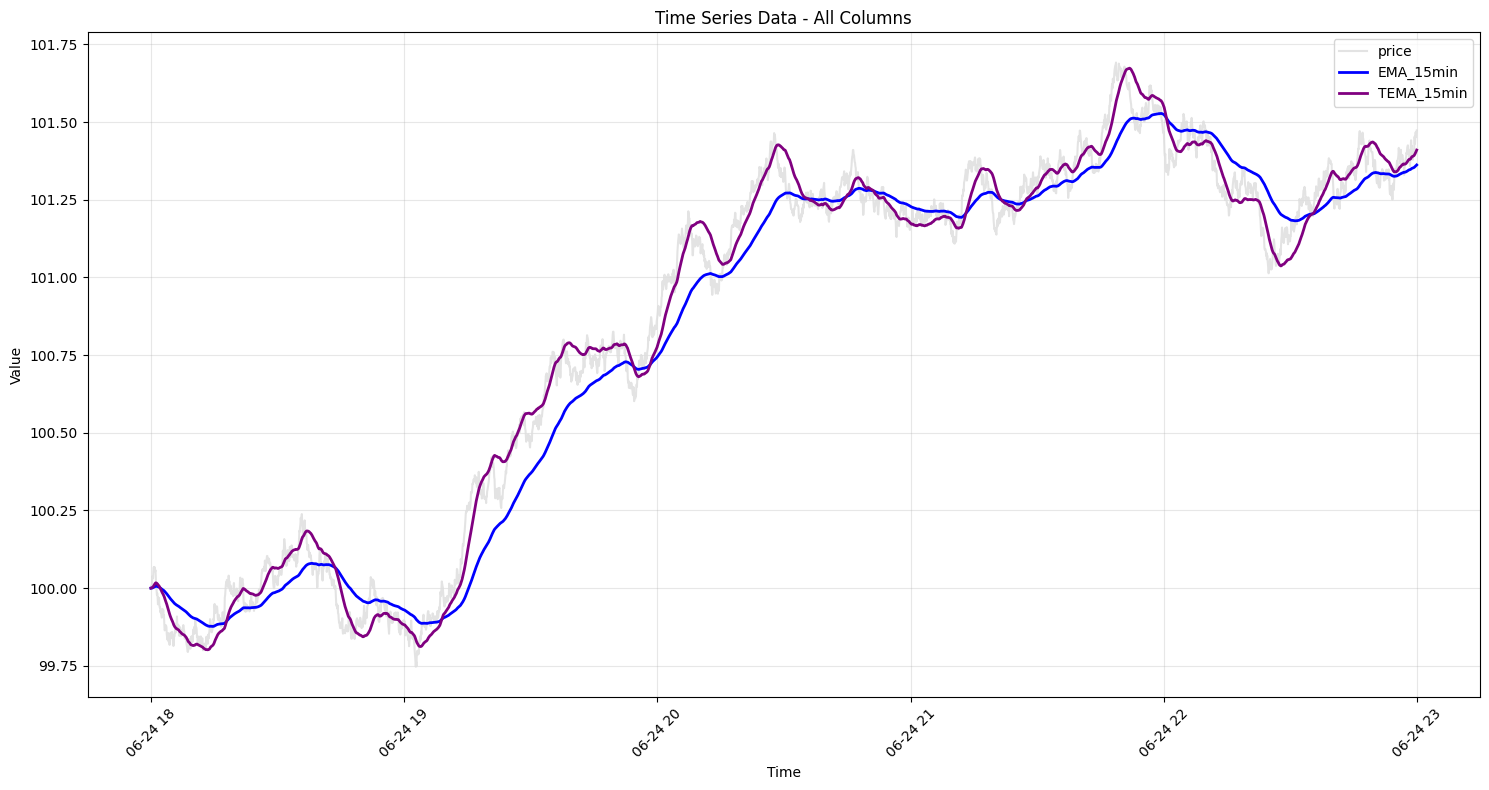

Plotted 3 columns: ['price', 'EMA_15min', 'TEMA_15min']


In [14]:
import matplotlib.pyplot as plt

def plot_time_series(df, exclude_columns=None):
    """
    Plot all columns except timestamp and excluded columns dynamically
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with timestamp column and data columns to plot
    exclude_columns : list or None
        List of column names to exclude from plotting (in addition to 'timestamp')
    """
    if exclude_columns is None:
        exclude_columns = []
    
    # Always exclude timestamp, plus any user-specified columns
    all_excluded = ['timestamp'] + exclude_columns
    
    plt.figure(figsize=(15, 8))
    
    # Find all columns except excluded ones
    plot_columns = [col for col in df.columns if col not in all_excluded]
    colors = ['#dddddd', 'blue', 'purple', 'green', 'purple', 'orange', 'brown', 'pink', 'olive', 'cyan', 'magenta']
    
    for i, col in enumerate(plot_columns):
        color = colors[i % len(colors)]  # Cycle through colors
        # Make first column (usually price) more prominent
        linewidth = 1.5 if i == 0 else 2
        alpha = 0.8 if i == 0 else 1.0
        plt.plot(df['timestamp'], df[col], 
                 color=color, linewidth=linewidth, alpha=alpha, label=col)
    
    plt.title('Time Series Data - All Columns')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    if exclude_columns:
        print(f"Excluded columns: {exclude_columns}")
    print(f"Plotted {len(plot_columns)} columns: {plot_columns}")

# Plot with no exclusions
plot_time_series(df, exclude_columns=None)

# Example: Plot excluding specific EMAs
# plot_time_series(stock_df, exclude_columns=['EMA_30min', 'EMA_60min'])

# Economic way to graph a moving average

In [22]:
from collections import deque
import pandas as pd
from datetime import datetime

class StreamingMovingAverage:
    """
    Efficient streaming moving average calculator that maintains state
    and calculates MA incrementally as new data points arrive.
    
    Uses a circular buffer (deque) for O(1) operations and running sum
    to avoid recalculating the entire average each time.
    """
    
    def __init__(self, window_size):
        """
        Initialize the streaming moving average calculator.
        
        Parameters:
        -----------
        window_size : int
            Number of data points to include in the moving average
        """
        self.window_size = window_size
        self.buffer = deque(maxlen=window_size)  # Circular buffer with fixed size
        self.sum = 0.0  # Running sum for O(1) average calculation
        self.timestamps = deque(maxlen=window_size)  # Store corresponding timestamps
        
    def add_data_point(self, timestamp, price):
        """
        Add a new data point and calculate the updated moving average.
        
        Parameters:
        -----------
        timestamp : datetime or str
            Timestamp of the data point
        price : float
            Price value
            
        Returns:
        --------
        dict
            Dictionary containing current MA, count of data points, and metadata
        """
        # Convert timestamp to datetime if it's a string
        if isinstance(timestamp, str):
            timestamp = pd.to_datetime(timestamp)
        
        # Check if buffer is full and we need to remove the oldest value
        if len(self.buffer) == self.window_size:
            # Remove the oldest value from the sum
            oldest_price = self.buffer[0]  # This will be automatically removed by deque
            self.sum -= oldest_price
        
        # Add the new price to buffer and sum
        self.buffer.append(price)
        self.timestamps.append(timestamp)
        self.sum += price
        
        # Calculate current moving average
        current_ma = self.sum / len(self.buffer)
        
        return {
            'timestamp': timestamp,
            'price': price,
            'moving_average': current_ma,
            'data_points': len(self.buffer),
            'is_full_window': len(self.buffer) == self.window_size,
            'window_start': self.timestamps[0] if self.timestamps else None,
            'window_end': self.timestamps[-1] if self.timestamps else None
        }
    
    def get_current_ma(self):
        """Get the current moving average without adding new data."""
        if len(self.buffer) == 0:
            return None
        return self.sum / len(self.buffer)
    
    def get_buffer_info(self):
        """Get information about the current buffer state."""
        return {
            'window_size': self.window_size,
            'current_count': len(self.buffer),
            'is_full': len(self.buffer) == self.window_size,
            'current_sum': self.sum,
            'current_ma': self.get_current_ma(),
            'oldest_timestamp': self.timestamps[0] if self.timestamps else None,
            'newest_timestamp': self.timestamps[-1] if self.timestamps else None,
            'price_range': (min(self.buffer), max(self.buffer)) if self.buffer else None
        }
    
    def reset(self):
        """Reset the moving average calculator."""
        self.buffer.clear()
        self.timestamps.clear()
        self.sum = 0.0

# Convenience function for simple usage
def create_streaming_ma(window_size):
    """
    Create a new streaming moving average calculator.
    
    Parameters:
    -----------
    window_size : int
        Number of data points in the moving average window
        
    Returns:
    --------
    StreamingMovingAverage
        New streaming MA calculator instance
    """
    return StreamingMovingAverage(window_size)


In [24]:
df

,timestamp,price,EMA_15min,TEMA_15min
0,2025-06-24 18:00:00,100.000000,100.000000,100.000000
1,2025-06-24 18:00:05,100.007558,100.000084,100.000248
2,2025-06-24 18:00:10,100.005455,100.000143,100.000421
3,2025-06-24 18:00:15,100.015311,100.000310,100.000914
4,2025-06-24 18:00:20,100.038490,100.000732,100.002156
...,...,...,...,...
3595,2025-06-24 22:59:35,101.449794,101.357438,101.399706
3596,2025-06-24 22:59:40,101.467491,101.358654,101.402468
3597,2025-06-24 22:59:45,101.452466,101.359691,101.404671
3598,2025-06-24 22:59:50,101.468014,101.360887,101.407331


In [25]:
# Use current DataFrame (df) with StreamingMovingAverage
print("🔄 USING CURRENT DATAFRAME WITH STREAMING MOVING AVERAGE")
print("=" * 60)

if 'df' in locals() and df is not None and len(df) > 0:
    print(f"📊 DataFrame Info:")
    print(f"   • Rows: {len(df):,}")
    print(f"   • Columns: {list(df.columns)}")
    print(f"   • Time Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"   • Price Range: {df['price'].min():.5f} to {df['price'].max():.5f}")
    
    # Create streaming moving averages with different window sizes
    ma_5_periods = create_streaming_ma(window_size=5)      # 5 data points (25 seconds for 5-sec data)
    ma_12_periods = create_streaming_ma(window_size=12)    # 12 data points (1 minute for 5-sec data)
    ma_60_periods = create_streaming_ma(window_size=60)    # 60 data points (5 minutes for 5-sec data)
    ma_180_periods = create_streaming_ma(window_size=180)  # 180 data points (15 minutes for 5-sec data)
    
    print(f"\n🎯 Created Streaming MAs:")
    print(f"   • MA_5 (25 seconds)")
    print(f"   • MA_12 (1 minute)")
    print(f"   • MA_60 (5 minutes)")
    print(f"   • MA_180 (15 minutes)")
    
    # Process the DataFrame through streaming MAs
    print(f"\n⚡ Processing {len(df)} data points through streaming MAs...")
    
    streaming_results = []
    
    # Process each row in the DataFrame
    for idx, row in df.iterrows():
        timestamp = row['timestamp']
        price = row['price']
        
        # Add data point to each MA calculator
        result_5 = ma_5_periods.add_data_point(timestamp, price)
        result_12 = ma_12_periods.add_data_point(timestamp, price)
        result_60 = ma_60_periods.add_data_point(timestamp, price)
        result_180 = ma_180_periods.add_data_point(timestamp, price)
        
        # Store results
        streaming_results.append({
            'timestamp': timestamp,
            'price': price,
            'MA_5': result_5['moving_average'],
            'MA_12': result_12['moving_average'],
            'MA_60': result_60['moving_average'],
            'MA_180': result_180['moving_average'],
            'MA_5_full': result_5['is_full_window'],
            'MA_12_full': result_12['is_full_window'],
            'MA_60_full': result_60['is_full_window'],
            'MA_180_full': result_180['is_full_window']
        })
    
    # Convert results to DataFrame
    streaming_df = pd.DataFrame(streaming_results)
    
    print(f"✅ Processing complete!")
    print(f"\n📈 STREAMING MA RESULTS:")
    print(f"   • Total processed: {len(streaming_df):,} data points")
    
    # Show when each MA window becomes full
    for ma_name, full_col in [('MA_5', 'MA_5_full'), ('MA_12', 'MA_12_full'), 
                              ('MA_60', 'MA_60_full'), ('MA_180', 'MA_180_full')]:
        full_idx = streaming_df[streaming_df[full_col]].index[0] if streaming_df[full_col].any() else None
        if full_idx is not None:
            full_time = streaming_df.loc[full_idx, 'timestamp']
            print(f"   • {ma_name} window full at index {full_idx} ({full_time})")
    
    # Show latest values
    print(f"\n📊 LATEST VALUES:")
    latest = streaming_df.iloc[-1]
    print(f"   • Timestamp: {latest['timestamp']}")
    print(f"   • Price: {latest['price']:.5f}")
    print(f"   • MA_5 (25s): {latest['MA_5']:.5f}")
    print(f"   • MA_12 (1m): {latest['MA_12']:.5f}")
    print(f"   • MA_60 (5m): {latest['MA_60']:.5f}")
    print(f"   • MA_180 (15m): {latest['MA_180']:.5f}")
    
    # Compare with existing EMAs (if they exist)
    if 'EMA_15min' in df.columns:
        existing_ema = df['EMA_15min'].iloc[-1]
        streaming_ma_15min = latest['MA_180']
        difference = abs(existing_ema - streaming_ma_15min)
        print(f"\n🔍 COMPARISON WITH EXISTING EMA:")
        print(f"   • Existing EMA_15min: {existing_ema:.5f}")
        print(f"   • Streaming MA_180 (15m): {streaming_ma_15min:.5f}")
        print(f"   • Difference: {difference:.5f}")
        print(f"   • Note: EMA and SMA use different calculation methods")
    
    # Show sample of recent data
    print(f"\n📋 RECENT STREAMING MA DATA (Last 5 rows):")
    display_cols = ['timestamp', 'price', 'MA_5', 'MA_12', 'MA_60', 'MA_180']
    print(streaming_df[display_cols].tail(5).to_string(index=False, float_format='%.5f'))
    
    # Store streaming results in a new variable for further use
    df_streaming = streaming_df.copy()
    
    print(f"\n💾 Results stored in 'df_streaming' variable")
    print(f"   • Contains: {list(df_streaming.columns)}")
    
else:
    print("❌ No DataFrame 'df' found or DataFrame is empty")
    print("   Please run the data generation cells first")

🔄 USING CURRENT DATAFRAME WITH STREAMING MOVING AVERAGE
📊 DataFrame Info:
   • Rows: 3,600
   • Columns: ['timestamp', 'price', 'EMA_15min', 'TEMA_15min']
   • Time Range: 2025-06-24 18:00:00 to 2025-06-24 22:59:55
   • Price Range: 99.74719 to 101.69176

🎯 Created Streaming MAs:
   • MA_5 (25 seconds)
   • MA_12 (1 minute)
   • MA_60 (5 minutes)
   • MA_180 (15 minutes)

⚡ Processing 3600 data points through streaming MAs...
✅ Processing complete!

📈 STREAMING MA RESULTS:
   • Total processed: 3,600 data points
   • MA_5 window full at index 4 (2025-06-24 18:00:20)
   • MA_12 window full at index 11 (2025-06-24 18:00:55)
   • MA_60 window full at index 59 (2025-06-24 18:04:55)
   • MA_180 window full at index 179 (2025-06-24 18:14:55)

📊 LATEST VALUES:
   • Timestamp: 2025-06-24 22:59:55
   • Price: 101.47320
   • MA_5 (25s): 101.46219
   • MA_12 (1m): 101.43242
   • MA_60 (5m): 101.39592
   • MA_180 (15m): 101.36993

🔍 COMPARISON WITH EXISTING EMA:
   • Existing EMA_15min: 101.36213


In [26]:
df_streaming

,timestamp,price,MA_5,MA_12,MA_60,MA_180,MA_5_full,MA_12_full,MA_60_full,MA_180_full
0,2025-06-24 18:00:00,100.000000,100.000000,100.000000,100.000000,100.000000,False,False,False,False
1,2025-06-24 18:00:05,100.007558,100.003779,100.003779,100.003779,100.003779,False,False,False,False
2,2025-06-24 18:00:10,100.005455,100.004338,100.004338,100.004338,100.004338,False,False,False,False
3,2025-06-24 18:00:15,100.015311,100.007081,100.007081,100.007081,100.007081,False,False,False,False
4,2025-06-24 18:00:20,100.038490,100.013363,100.013363,100.013363,100.013363,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
3595,2025-06-24 22:59:35,101.449794,101.431860,101.414238,101.387561,101.367512,True,True,True,True
3596,2025-06-24 22:59:40,101.467491,101.443695,101.417981,101.389710,101.368163,True,True,True,True
3597,2025-06-24 22:59:45,101.452466,101.450660,101.420381,101.391434,101.368658,True,True,True,True
3598,2025-06-24 22:59:50,101.468014,101.453625,101.425738,101.393626,101.369223,True,True,True,True


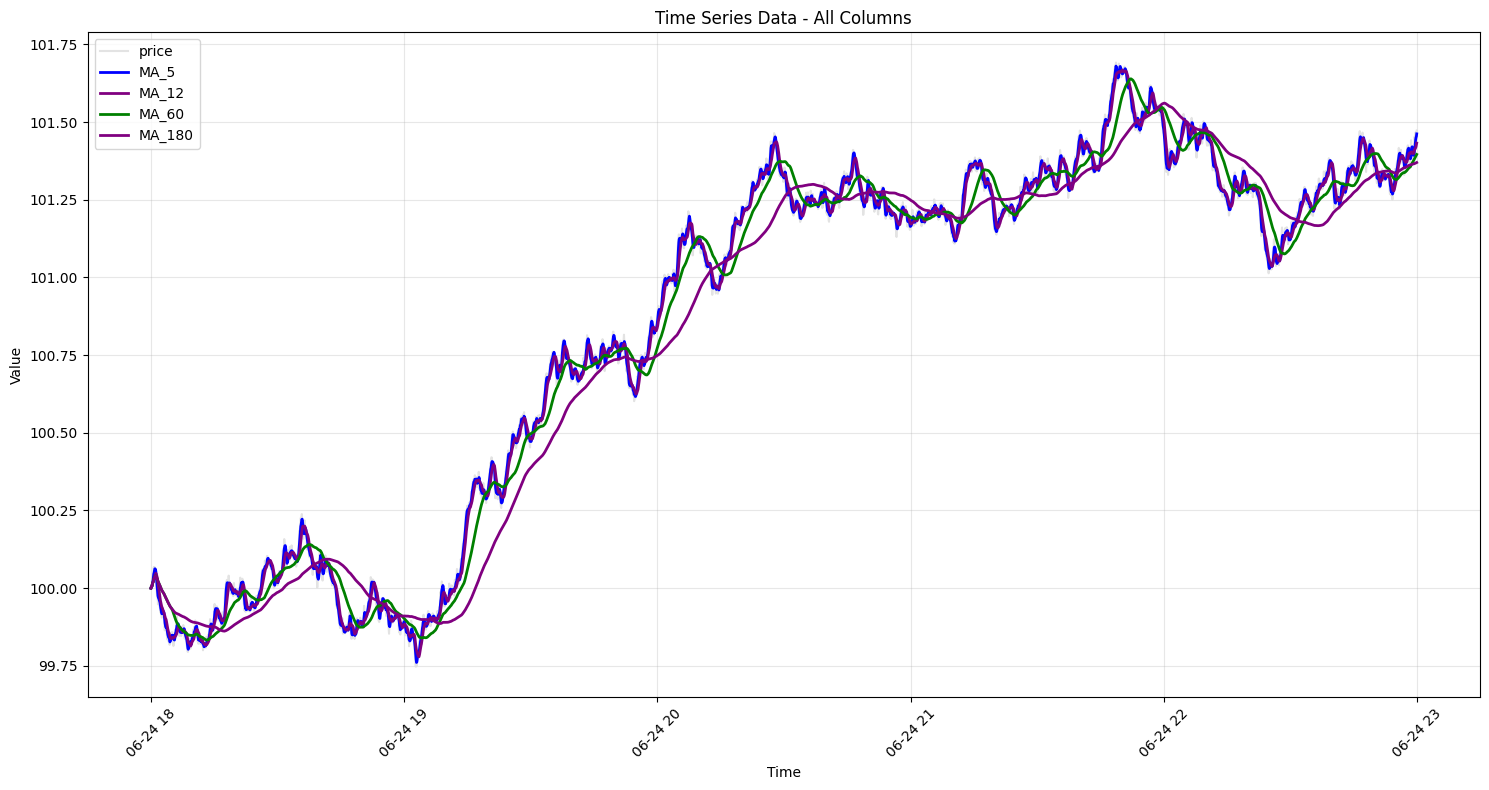

Excluded columns: ['MA_5_full', 'MA_12_full', 'MA_60_full', 'MA_180_full']
Plotted 5 columns: ['price', 'MA_5', 'MA_12', 'MA_60', 'MA_180']


In [21]:
plot_time_series(df_streaming, exclude_columns=['MA_5_full', 'MA_12_full', 'MA_60_full', 'MA_180_full'])

In [27]:
# save df_streaming to CSV
df_streaming.to_csv('streaming_moving_average_results.csv', index=False)
print("✅ Streaming moving average results saved to 'streaming_moving_average_results.csv'")

✅ Streaming moving average results saved to 'streaming_moving_average_results.csv'
